In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from langdetect import detect
import re

Setup

In [133]:
plt.style.use('bmh')
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janramdohr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Survey data processing

In [134]:
data = pd.read_csv('../data/original/survey/survey.csv', parse_dates=['Start Date'], usecols = ['Start Date','introduction','floor','ground-floor','1-floor','2-floor','emotion','comfort','space usage','occupation','usage'])

convert survey data to correct timezone

In [135]:
data['Start Date'] = data['Start Date'].dt.tz_localize('America/Denver')
data['Start Date'] = data['Start Date'].dt.tz_convert('Europe/Amsterdam')

convert location question data to known place ids

In [136]:
def assign_place_id(row):
    if row['floor'] == 'Ground floor' and row['ground-floor'] == 'Round tables by the three plants (across wooden staircase)':
        return 1
    elif row['floor'] == 'Ground floor' and row['ground-floor'] == 'Study corner next to the plant wall':
        return 2
    elif row['floor'] == '1st Floor' and row['1-floor'] == 'Green group study tables (between a row of plants and railing)':
        return 3
    elif row['floor'] == '1st Floor' and row['1-floor'] == 'Tables on the landing (with wooden floor) accessible by the black staircase':
        return 3
    elif row['floor'] == '1st Floor' and row['1-floor'] == 'Yellow/white chairs & tables (besides the wooden staircase)':
        return 4
    else:
        return 0

data['place_id'] = data.apply(assign_place_id, axis=1)

In [137]:
data = data.loc[data['introduction'] == 'I understand, and I agree to participate in the survey']

drop unneeded columns and rename the rest appropriately

In [138]:
data = data.drop(columns=['floor','ground-floor','1-floor','2-floor','introduction'])
data = data.rename(columns={'usage':'frequent_use','occupation':'isStudent','space usage':'activity'})

Properly assign numeric values:

1. Learning / Working by yourself
2. Learning / Working in a group
3. Taking a break

In [139]:
def assign_activity_id(row):
    if row['activity'] == 'Learning / Working by yourself':
        return 1
    elif row['activity'] == 'Learning / Working in a group':
        return 2
    elif row['activity'] == 'Taking a break':
        return 3
    else:
        return 0

data['activity'] = data.apply(assign_activity_id, axis=1)


data['frequent_use'] = data['frequent_use'].map(dict(Yes=1, No=0))
data['isStudent'] = data['isStudent'].map(dict(Yes=1, No=0))

In [140]:
data['emotion'] = data['emotion'].astype(str)
data['comfort'] = data['comfort'].astype(str)

detect answers not written in english

In [141]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

data['language_emotion'] = data['emotion'].apply(detect_language)   
data['language_comfort'] = data['comfort'].apply(detect_language)

non_english = data[(data['language_emotion'] != 'en') & (data['language_comfort'] != 'en')]
non_english

,Start Date,emotion,comfort,activity,isStudent,frequent_use,place_id,language_emotion,language_comfort
2,2023-05-03 13:22:43+02:00,Rustig,8/10,2,0.0,0.0,1,af,unknown
18,2023-05-09 11:21:03+02:00,Relaxed,Quite comfortable,3,1.0,1.0,4,so,fr
26,2023-05-09 14:21:39+02:00,Rustgevend mooi uitzicht,Wel redelijk veel geluid,1,1.0,1.0,3,nl,nl
29,2023-05-09 15:20:12+02:00,Pretty calm,A bit loud,2,1.0,1.0,4,it,ca
32,2023-05-03 13:12:22+02:00,nan,nan,0,NaN,NaN,3,tl,tl
42,2023-05-11 11:32:21+02:00,"Kalm, rustig","Wel goed, lekker rustig",2,1.0,1.0,4,et,af
56,2023-05-15 14:54:11+02:00,Calm,nan,2,1.0,1.0,4,ca,tl
65,2023-05-09 14:51:01+02:00,nan,nan,0,NaN,NaN,1,tl,tl
71,2023-05-10 10:17:34+02:00,nan,nan,0,NaN,NaN,3,tl,tl


Translations based on deepl.com

In [142]:
data.loc[2, 'emotion'] = 'Quiet'
data.loc[26, 'emotion'] = 'Soothingly beautiful view'
data.loc[26, 'comfort'] = 'Quite a lot of noise though'
data.loc[42, 'emotion'] = 'Calm, quiet'
data.loc[42, 'comfort'] = 'All right, nice and quiet'

Tokenize words and stencences and stem words for further analysis

In [143]:
def stem_words(words):
    stemmer = nltk.stem.PorterStemmer()
    return [stemmer.stem(word) for word in words]

data['emotion_tokens'] = data['emotion'].apply(nltk.word_tokenize)
data['comfort_tokens'] = data['comfort'].apply(nltk.word_tokenize)

data['emotion_tokens_stem'] = data['emotion_tokens'].apply(stem_words)
data['comfort_tokens_stem'] = data['comfort_tokens'].apply(stem_words)


Analyse some basic parameters of the survey data.


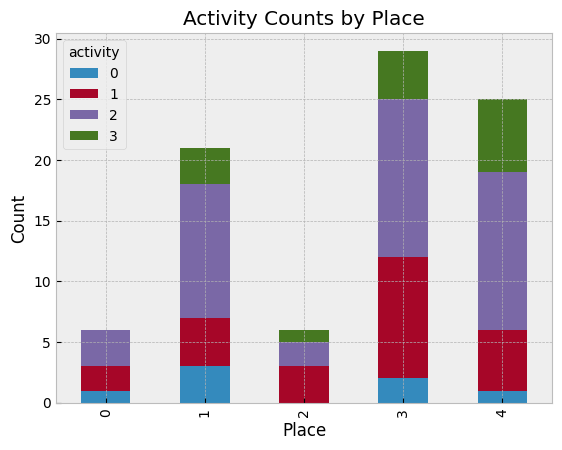

In [144]:
data_count = data.groupby(['place_id', 'activity']).size().reset_index(name='count')
pivot = data_count.pivot(index='place_id', columns='activity', values='count')
pivot.plot(kind='bar', stacked=True)


plt.xlabel('Place')
plt.ylabel('Count')
plt.title('Activity Counts by Place')
plt.show()

In [148]:
stemmed_words_comfort = [word for sublist in data['comfort_tokens_stem'] for word in sublist]
stemmed_words_emotion = [word for sublist in data['emotion_tokens_stem'] for word in sublist]

stop_words = set(nltk.corpus.stopwords.words('english'))
stemmed_words_comfort= [word for word in stemmed_words_comfort if word not in stop_words]
stemmed_words_emotion= [word for word in stemmed_words_emotion if word not in stop_words]

punctuation = string.punctuation + '’'

stemmed_words_comfort = [word for word in stemmed_words_comfort if word not in punctuation]
stemmed_words_emotion = [word for word in stemmed_words_emotion if word not in punctuation]

fdist_comfort = nltk.probability.FreqDist(stemmed_words_comfort)
fdist_emotion = nltk.probability.FreqDist(stemmed_words_emotion)

print("comfort:")
for word, frequency in fdist_comfort.most_common(500):
    print(f'{word}: {frequency}')

print("")

print("emotion:")
for word, frequency in fdist_emotion.most_common(500):
    print(f'{word}: {frequency}')

comfort:
comfort: 43
light: 30
veri: 20
feel: 20
temperatur: 19
nois: 19
good: 18
bit: 16
nice: 13
air: 12
pretti: 11
space: 10
much: 10
quit: 10
noisi: 10
qualiti: 9
chair: 9
peopl: 8
plant: 8
like: 8
cold: 7
littl: 7
fine: 7
enough: 7
nan: 7
's: 6
although: 6
also: 6
perfect: 5
loud: 5
bright: 5
tabl: 5
becaus: 5
make: 5
great: 5
sit: 5
everyth: 4
overal: 4
realli: 4
focu: 4
thi: 4
distract: 4
break: 4
talk: 4
background: 4
studi: 4
build: 4
could: 4
better: 4
around: 4
ani: 3
particularli: 3
hard: 3
lectur: 3
bother: 3
okay: 3
warm: 3
higher: 3
floor: 3
lot: 3
green: 3
howev: 3
right: 3
quiet: 3
come: 3
smell: 3
help: 3
notic: 2
uncomfort: 2
well-lit: 2
get: 2
open: 2
7/10: 2
somewhat: 2
seat: 2
wa: 2
student: 2
window: 2
ceil: 2
sound: 2
coffe: 2
wrong: 2
level: 2
fairli: 2
want: 2
constant: 2
enter: 2
sometim: 2
fresh: 2
dark: 2
walk: 2
opinion: 2
ground: 2
place: 2
hot: 2
noic: 2
comfi: 2
onli: 2
big: 2
give: 2
vibe: 2
usual: 2
amount: 2
favourit: 2
movement: 2
due: 2
noth: 2
sta

## Bert

In [149]:
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

In [75]:
sentences = data['comfort']

sentiment_scores = []

for sentence in sentences:
    # tokenize the sentence and return tensors
    inputs = tokenizer(sentence, return_tensors='pt')

    # get the model outputs
    outputs = model(**inputs)

    # the model returns the logits
    # the sentiment score can be computed using a softmax function
    sentiment = torch.nn.functional.softmax(outputs.logits, dim=1)


    labels = ['negative', 'neutral', 'positive']
    sentiment_label = labels[sentiment.argmax(dim=1).item()]

    sentiment_scores.append(sentiment_label)

# add the sentiment scores to your dataframe
data['bert_sentiment_score'] = sentiment_scores

In [76]:
sentences = data['emotion']

sentiment_scores = []

for sentence in sentences:
    # tokenize the sentence and return tensors
    inputs = tokenizer(sentence, return_tensors='pt')

    # get the model outputs
    outputs = model(**inputs)

    # the model returns the logits
    # the sentiment score can be computed using a softmax function
    sentiment = torch.nn.functional.softmax(outputs.logits, dim=1)

    labels = ['negative', 'neutral', 'positive']
    sentiment_label = labels[sentiment.argmax(dim=1).item()]

    sentiment_scores.append(sentiment_label)

# add the sentiment scores to your dataframe
data['bert_sentiment_score_emotion'] = sentiment_scores

In [121]:
data[['emotion','bert_sentiment_score_emotion','comfort', 'bert_sentiment_score']]

,emotion,bert_sentiment_score_emotion,comfort,bert_sentiment_score
0,I feel pretty calm and relaxed.,positive,"I don’t notice any uncomfortable factors. Temperature is good, noise is low and everything is well-lit. Pretty comfortable overall.",positive
1,"I really like it! It’s fairly quiet right now as a lot of students are on break, but there’s a nice amount of background noise, and the light is nice!",positive,Very comfortable! Perfect temperature,positive
2,Quiet,neutral,8/10,neutral
3,"social, but still a nice place to study. It can get a little noise at times though",positive,It get cold,neutral
4,"Having computer issues so stressed, not really focused",negative,Pretty good but it's a bit too loud and open to really focus,neutral
5,"It's very quiet here right now, so I am feeling at ease and able to concentrate",positive,"It's a little chilly, but I don't particularly mind that. Otherwise it's very comfortable",positive
6,"Pretty calm and no emotions, just finished my lunch",positive,7/10,neutral
7,"I'm feeling alright at the moment, only a bit tired and its really gezellig here",positive,Pretty comfortable,positive
8,"It’s quite relaxing, although the students having a break from their lecture is quite distracting. I am grateful for my noise cancelling earphones.I feel mostly at ease here, no particularly strong emotion.",positive,"Although this answer feels somewhat lazily construed, everything is just fine. The seats (sofa in my case) is fin, not too soft and not too hard, the lights aren’t too bright nor too dim, the air quality (although I’m certainly not an expert on this) is supreme. The noise was somewhat distracting during the other students’ lecture break. I also noticed opening my tin can was awkwardly loud, although that lasted for a mere millisecond.",positive
9,The openness of the space and the plants on the wall give a relaxed feeling,positive,"The chairs feel a little hard, but not too hard. The table is on a good height. The space is well-lit through the use of windows on the ceiling and lights. I can hear some people talking, but the sounds of the coffee dispenser distract me the most.",positive


# Aspect based sentiment analysis

create environment parameter related list

In [125]:
# Define your parameters
parameters = {
    "sound": ["nois", "noisi", "loud", "quiet", "sound", "hear"],
    "light": ["bright", "light", "well-lit"],
    "air": ["air", "smell", "fresh"],
    "temperature": ["temperatur", "cold", "warm", "hot"]
}

# Initialize the stemmer
ps = nltk.stem.PorterStemmer()

def custom_split(text):
    # Split on full-stop and comma first
    first_split = re.split('\. |, |\! ', text)

    # Container for the final split sentences
    final_split = []

    for sentence in first_split:
        # If ' and ' is in the sentence, perform additional checks
        if ' and ' in sentence:
            subsentences = sentence.split(' and ')
            # Reverse split if one of the subsentences is one word long or is 'the' plus a word
            if any(len(subsentence.split()) <= 2 for subsentence in subsentences):
                final_split.append(sentence)
            else:
                final_split.extend(subsentences)
        else:
            final_split.append(sentence)
    
    return final_split

# Stemming function
def stem_sentence(sentence):
    words = nltk.tokenize.word_tokenize(sentence)
    stemmed_words = [ps.stem(word) for word in words]
    return stemmed_words

def split_and_group(text):
    # Split the sentence
    split_sentences = custom_split(text)
    
    # Create an empty list for each parameter
    param_sentences = {param: [] for param in parameters.keys()}
    
    # Check each subsentence for stems
    for subsentence in split_sentences:
        stemmed_sentence = stem_sentence(subsentence)
        for param, stems in parameters.items():
            # Initialize a flag variable as False
            found_stem = False
            # Iterate over each stem
            for stem in stems:
                # If stem is found in the list of stemmed words
                if stem in stemmed_sentence:
                    found_stem = True
                    break  # No need to check the remaining stems
            
            # Check if any stem was found
            if found_stem:
                param_sentences[param].append(subsentence.strip())
    
    return param_sentences

# Apply the function to your DataFrame column
grouped_sentences = data['comfort'].apply(split_and_group)

# Create a new column for each parameter group
for param in parameters.keys():
    data[param] = grouped_sentences.apply(lambda x: x[param])

0                                                                                                                                                                                                    {'sound': ['noise is low'], 'light': ['everything is well-lit'], 'air': [], 'temperature': ['Temperature is good']}
1                                                                                                                                                                                                                                          {'sound': [], 'light': [], 'air': [], 'temperature': ['Perfect temperature']}
2                                                                                                                                                                                                                                                               {'sound': [], 'light': [], 'air': [], 'temperature': []}
3                                                            

In [126]:
data[["comfort","sound","light","air","temperature"]]

,comfort,sound,light,air,temperature
0,"I don’t notice any uncomfortable factors. Temperature is good, noise is low and everything is well-lit. Pretty comfortable overall.",[noise is low],[everything is well-lit],[],[Temperature is good]
1,Very comfortable! Perfect temperature,[],[],[],[Perfect temperature]
2,8/10,[],[],[],[]
3,It get cold,[],[],[],[It get cold]
4,Pretty good but it's a bit too loud and open to really focus,[Pretty good but it's a bit too loud],[],[],[]
5,"It's a little chilly, but I don't particularly mind that. Otherwise it's very comfortable",[],[],[],[]
6,7/10,[],[],[],[]
7,Pretty comfortable,[],[],[],[]
8,"Although this answer feels somewhat lazily construed, everything is just fine. The seats (sofa in my case) is fin, not too soft and not too hard, the lights aren’t too bright nor too dim, the air quality (although I’m certainly not an expert on this) is supreme. The noise was somewhat distracting during the other students’ lecture break. I also noticed opening my tin can was awkwardly loud, although that lasted for a mere millisecond.","[The noise was somewhat distracting during the other students’ lecture break, I also noticed opening my tin can was awkwardly loud]",[the lights aren’t too bright nor too dim],[the air quality (although I’m certainly not an expert on this) is supreme],[]
9,"The chairs feel a little hard, but not too hard. The table is on a good height. The space is well-lit through the use of windows on the ceiling and lights. I can hear some people talking, but the sounds of the coffee dispenser distract me the most.","[I can hear some people talking, but the sounds of the coffee dispenser distract me the most.]",[The space is well-lit through the use of windows on the ceiling and lights],[],[]


In [8]:
sentences = ['I like the light background noise of the room', 'but it is too cold']

sentiment_scores = []

for sentence in sentences:
    # tokenize the sentence and return tensors
    inputs = tokenizer(sentence, return_tensors='pt')

    # get the model outputs
    outputs = model(**inputs)

    # the model returns the logits
    # the sentiment score can be computed using a softmax function
    sentiment = torch.nn.functional.softmax(outputs.logits, dim=1)

    labels = ['negative', 'neutral', 'positive']
    sentiment_label = labels[sentiment.argmax(dim=1).item()]

    sentiment_scores.append(sentiment_label)

# add the sentiment scores to your dataframe
sentiment_scores

['positive', 'negative']